## Work Flow

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the
provided data for this analysis.
   
2. Build a predictive model to help determine the probability that a rider will
be retained.

3. Evaluate the model.  Focus on metrics that are important for your *statistical
model*.
 
4. Identify / interpret features that are the most influential in affecting
your predictions.

5. Discuss the validity of your model. Issues such as
leakage.  For more on leakage, see [this essay on
Kaggle](https://www.kaggle.com/dansbecker/data-leakage), and this paper: [Leakage in Data
Mining: Formulation, Detection, and Avoidance](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.365.7769&rep=rep1&type=pdf).

6. Repeat 2 - 5 until you have a satisfactory model.

7. Consider business decisions that your model may indicate are appropriate.
Evaluate possible decisions with metrics that are appropriate for *decision
rules*.

## Deliverables

- Code you used to build the model.  The more repeatable, self explanatory, the
  better.

- A presentation including the following points:
  - How did you compute the target?
  - What model did you use in the end? Why?
  - Alternative models you considered? Why are they not good enough?
  - What performance metric did you use to evaluate the *model*? Why?
  - **Based on insights from the model, what plans do you propose to
    reduce churn?**
  - What are the potential impacts of implementing these plans or decisions?
    What performance metrics did you use to evaluate these *decisions*, why?

## Problem Description

A ride-sharing company (Company X) is interested in predicting rider retention.
To help explore this question, we have provided a sample dataset of a cohort of
users who signed up for an account in January 2014. The data was pulled on July
1, 2014; we consider a user retained if they were “active” (i.e. took a trip)
in the preceding 30 days (from the day the data was pulled). In other words, a
user is "active" if they have taken a trip since June 1, 2014. The data,
`churn.csv`, is in the [data](data) folder.  The data are split into train and
test sets.  You are encouraged to tune and estimate your model's performance on
the train set, then see how it does on the unseen data in the test set at the
end.

- The 'Feature Importance' discussion is in Random Forests lecture
- Also discussed on page 262 of hands-on

### Numerical Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from churn_eda import clean_data

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use("ggplot")

### Learning Libraries

In [3]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression

### Load in Data

In [4]:
df = pd.read_csv('data/churn_train.csv')

train = pd.read_csv('data/churn_train.csv')

In [5]:
df = clean_data(df)

train = clean_data(train)

In [6]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,avg_rating_of_driver_nan,avg_rating_by_driver_nan,days_since_signup
0,6.94,5.0,5.000000,1.00,Astapor,Android,0.0,0,False,100.0,1,0,0,170
1,8.06,5.0,5.000000,1.00,Astapor,Android,0.0,2,True,0.0,1,0,0,157
2,21.50,4.0,4.601697,1.00,Winterfell,iPhone,0.0,1,True,100.0,1,1,0,180
3,9.46,5.0,4.601697,2.75,Winterfell,Android,100.0,1,False,100.0,1,1,0,173
4,13.77,5.0,4.601697,1.00,Winterfell,iPhone,0.0,0,False,100.0,1,1,0,151


## One Hot Encode Categorical

In [7]:
from onehotencoding import set_ohe

In [8]:
df = set_ohe(df, 'city')
df = set_ohe(df, 'phone')

In [9]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,avg_rating_of_driver_nan,avg_rating_by_driver_nan,days_since_signup,city: Winterfell,city: Astapor,phone: iPhone,phone: Android
0,6.94,5.0,5.000000,1.00,0.0,0,False,100.0,1,0,0,170,0.0,1.0,0.0,1.0
1,8.06,5.0,5.000000,1.00,0.0,2,True,0.0,1,0,0,157,0.0,1.0,0.0,1.0
2,21.50,4.0,4.601697,1.00,0.0,1,True,100.0,1,1,0,180,1.0,0.0,1.0,0.0
3,9.46,5.0,4.601697,2.75,100.0,1,False,100.0,1,1,0,173,1.0,0.0,0.0,1.0
4,13.77,5.0,4.601697,1.00,0.0,0,False,100.0,1,1,0,151,1.0,0.0,1.0,0.0


## Train/Test Split

In [10]:
y = df.pop('churn').values
X = df.values

In [11]:
y

array([1, 1, 1, ..., 0, 1, 0])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## OLS

In [13]:
# ols = sm.OLS(y_train, X_train).fit()
# ols.summary()

In [14]:
# ols_results = ols.predict(X_test)
# print('OLS MSE: ', mean_squared_error(y_test, ols_results))
# print('OLS R2: ', r2_score(y_test, ols_results))

## Logistic Regression

### Test 1: No tuning, simple run

In [15]:
lr = LogisticRegression()

In [16]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
results = lr.predict(X_test)
results

array([1, 1, 0, ..., 0, 1, 1])

In [18]:
lr_cols = np.array(df.columns).reshape(-1,1)
lr_coefs = np.round(lr.coef_, 2).reshape(-1,1)

In [19]:
lr_col_coefs = np.concatenate((lr_cols, lr_coefs), axis=1)
lr_coefs_df = pd.DataFrame(lr_col_coefs, columns=['Feature Names', 'Coefficients'])
lr_coefs_df

,Feature Names,Coefficients
0,avg_dist,0.03
1,avg_rating_by_driver,0.16
2,avg_rating_of_driver,0.08
3,avg_surge,0.13
4,surge_pct,-0
5,trips_in_first_30_days,-0.11
6,luxury_car_user,-0.87
7,weekday_pct,0
8,avg_rating_of_driver_nan,0.7
9,avg_rating_by_driver_nan,0.35


In [20]:
print(f'Logistic Regression MSE      : {mean_squared_error(y_test, results):2.5f}')
print(f'Logistic Regression R2       : {r2_score(y_test, results):2.5f}')
print(f'Logistic Regression Accuracy : {accuracy_score(y_test, results):2.5f}')
print(f'Logistic Regression Precision: {precision_score(y_test, results):2.5f}')
print(f'Logistic Regression Recall   : {recall_score(y_test, results):2.5f}')

Logistic Regression MSE      : 0.27700
Logistic Regression R2       : -0.17572
Logistic Regression Accuracy : 0.72300
Logistic Regression Precision: 0.73872
Logistic Regression Recall   : 0.85597


In [21]:
confusion_matrix(y_test, results)

array([[1923, 1877],
       [ 893, 5307]])

### Test 2: With KFolds

In [42]:
def k_folds_models(X_data, y_data, num_splits, penalty='l2'):
    kfold = KFold(n_splits=num_splits)
    
    models = []
    mse = []
    accuracies = []
    precisions = []
    recalls = []
    
    fpr = []
    tpr = []
    thresholds = []
    
    for train, validation in kfold.split(X_data):
        lr_2 = LogisticRegression(penalty=penalty)
        lr_2.fit(X_data[train], y_data[train])
        pred = lr_2.predict(X_data[validation])
        
        #save each model to go back for reference
        models.append(lr_2)
        
        #mean squared error of the y_test values and the predicted
        err = mean_squared_error(y_train[validation], pred)
        mse.append(err)
        
        #accuracy scores
        accu = accuracy_score(y_train[validation], pred)
        accuracies.append(accu)
        
        #precision scores
        precise = precision_score(y_train[validation], pred)
        precisions.append(precise)
        
        #recall scores
        recall = recall_score(y_train[validation], pred)
        recalls.append(recall)
        
        fpr_val, tpr_val, thresholds_val = roc_curve(y_train[validation], pred)
        
        fpr.append(fpr_val)
        tpr.append(tpr_val)
        thresholds.append(thresholds_val)
        
    return (models, mse, accuracies, precisions, recalls, fpr, tpr, thresholds)

In [29]:
num_splits = 3
model_3, mse_3, accuracies_3, precisions_3, recalls_3= k_folds_models(X_train, y_train, num_splits)

print(f'Logistic Regression with KFolds: {num_splits} \n')
print(f'     Average Accuracy Score  : {np.mean(accuracies_3):2.5f}')
print(f'     Average Precision Score : {np.mean(precisions_3):2.5f}')
print(f'     Average Recall Score    : {np.mean(recalls_3):2.5f}')
print(f'     Average MSE Score       : {np.mean(mse_3):2.5f}')

Logistic Regression with KFolds: 3 

     Average Accuracy Score  : 0.72663
     Average Precision Score : 0.74434
     Average Recall Score    : 0.85757
     Average MSE Score       : 0.27337


In [30]:
num_splits = 5
model, mse, accuracies, precisions, recalls= k_folds_models(X_train, y_train, num_splits)

print(f'Logistic Regression with KFolds: {num_splits} \n')
print(f'     Average Accuracy Score  : {np.mean(accuracies):2.5f}')
print(f'     Average Precision Score : {np.mean(precisions):2.5f}')
print(f'     Average Recall Score    : {np.mean(recalls):2.5f}')
print(f'     Average MSE Score       : {np.mean(mse):2.5f}')

Logistic Regression with KFolds: 5 

     Average Accuracy Score  : 0.72597
     Average Precision Score : 0.74384
     Average Recall Score    : 0.85709
     Average MSE Score       : 0.27403


In [43]:
num_splits = 10
model, mse, accuracies, precisions, recalls, fpr, tpr, thresholds = k_folds_models(X_train, y_train, num_splits)

print(f'Logistic Regression with KFolds: {num_splits} \n')
print(f'     Average Accuracy Score  : {np.mean(accuracies):2.5f}')
print(f'     Average Precision Score : {np.mean(precisions):2.5f}')
print(f'     Average Recall Score    : {np.mean(recalls):2.5f}')
print(f'     Average MSE Score       : {np.mean(mse):2.5f}')

Logistic Regression with KFolds: 10 

     Average Accuracy Score  : 0.72620
     Average Precision Score : 0.74393
     Average Recall Score    : 0.85745
     Average MSE Score       : 0.27380


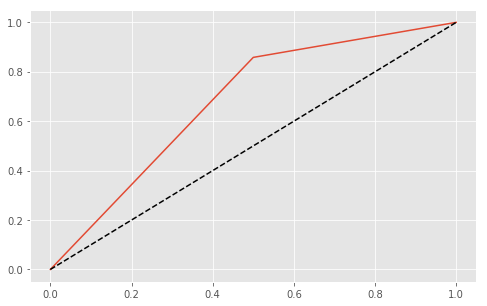

In [51]:
fig, ax = plt.subplots(figsize=(8,5))

colors

for i in range(len(fpr)):
    ax.plot(fpr[i], tpr[i])
    ax.plot([0,1], [0,1], 'k--')
    plt.show()

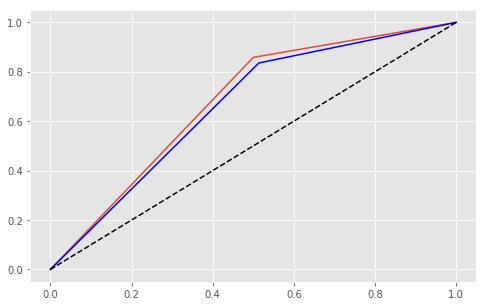

In [52]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(fpr[0], tpr[0])
ax.plot(fpr[1], tpr[1], color='b')
ax.plot([0,1], [0,1], 'k--')
plt.show()

In [34]:
# cols_kfolds_10 = np.array(df.columns).reshape(-1,1)
# coefs_kfolds_10 = np.round(lr_2.coef_, 2).reshape(-1,1)
# col_coefs_kfolds_10 = np.concatenate((lr_cols, lr_coefs), axis=1)
# df_kfolds_10 = pd.DataFrame(lr_col_coefs, columns=['Feature Names', 'Coefficients'])
# df_kfolds_10